In [ ]:
# !pip install xplotter --upgrade
# !pip install pycountry-convert
# !pip install geopy
# !pip install folium
# !pip install geopandas

In [1]:
# Importing libraries
import pandas as pd
import os
from warnings import filterwarnings
filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Maps
import folium
from folium.plugins import Fullscreen
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2, country_name_to_country_alpha3, country_alpha2_to_country_name
from geopy.geocoders import Nominatim
import geopandas as gpd

# Xplotter
from xplotter.insights import *
from xplotter.formatter import format_spines

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

<a id="2"></a>
<font color="darkslateblue" size=+2.5><b>Reading the Data</b></font>


In [2]:
# Reading the csv file
df = pd.read_csv('netflix_titles.csv')
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

The dataset has 7787 rows and 12 columns


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [4]:
#df.release_year.value_counts()

In [5]:
df['date_added_year']=df.date_added.str.split(',').str[-1]


In [6]:
df['date_added_year'].value_counts().sort_index()

 2008       2
 2009       2
 2010       1
 2011      13
 2012       3
 2013      11
 2014      25
 2015      88
 2016     443
 2017    1225
 2018    1685
 2019    2153
 2020    2009
 2021     117
Name: date_added_year, dtype: int64

In [7]:
df['date_added_month']=df.date_added.str.split(' ').str[-3]

In [8]:
df[df['date_added_year']==' 2021'].date_added_month.value_counts()

January    117
Name: date_added_month, dtype: int64

In [9]:
df.type.value_counts()

Movie      5377
TV Show    2410
Name: type, dtype: int64

<a id="3"></a>
<font color="darkslateblue" size=+2.5><b>EDA: Exploring Insights with xplotter</b></font>



<a id=""></a>
<font color="dimgrey" size=+2.0><b>TV Shows or Movies?</b></font>



The first question that can be in mind by looking at the data is: does Netflix have more tv shows or movies? This is a good question to answear using the data itself. So let's get our hands dirty and use our first function of `xplotter` for plotting a custom chart for looking at the balance between tv shows and movies.

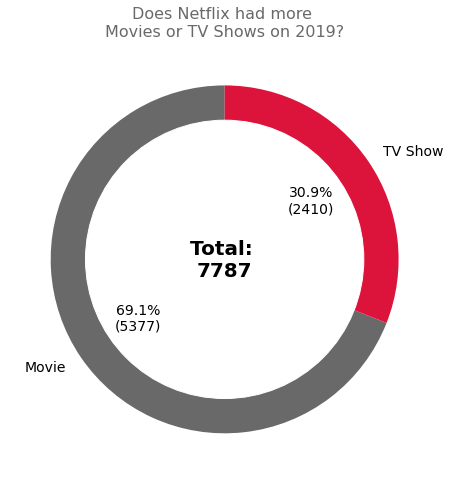

In [10]:
# Balance of Netflix products
plot_donut_chart(df=df, col='type', colors=['dimgrey', 'crimson'],
                 title='Does Netflix had more \nMovies or TV Shows on 2019?')

As per data Netflix has (or had) more movies than TV shows in a percentage of 69% against 31% approximately. But this lends us to the next question: is this a normal behavior? For ansewaring this question we should have in hands information about previous years of Netflix catalog but, if we take a look at the **date_added** column, maybe we could make an evolution analysis on how the balance of movies and TV shows showed up for Netflix's customers.

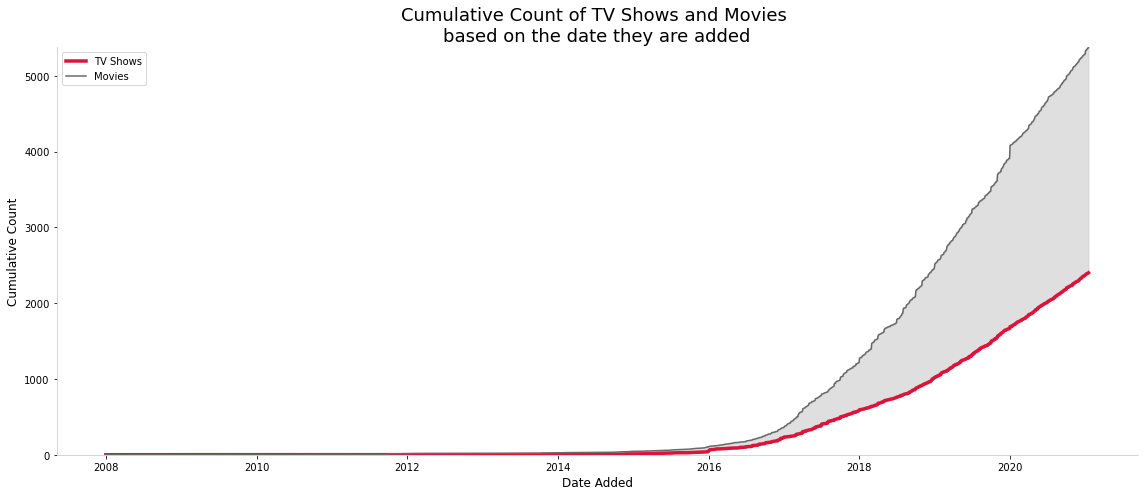

In [11]:
# Creating a new datetime column for date_added info
df_prep = df.copy()
df_prep['date_added_dt'] = pd.to_datetime(df_prep['date_added'])

# Creating new columns for movie type
df_prep['is_tvshow'] = (df_prep['type'] == 'TV Show') * 1
df_prep['is_movie'] = (df_prep['type'] == 'Movie') * 1

# Sorting by date and applying a cumulative sum on type flags
df_prep.sort_values(by='date_added_dt', inplace=True)
df_prep['cumul_tvshow'] = df_prep['is_tvshow'].cumsum()
df_prep['cumul_movie'] = df_prep['is_movie'].cumsum()

# Plotting figure
fig, ax = plt.subplots(figsize=(16, 7))
sns.lineplot(x='date_added_dt', y='cumul_tvshow', data=df_prep, ax=ax, 
             color='crimson', label='TV Shows', linewidth=3.5, markers='x')
sns.lineplot(x='date_added_dt', y='cumul_movie', data=df_prep, ax=ax, 
             color='dimgrey', label='Movies')

# Extracting max y value
max_tvshow = df_prep['cumul_tvshow'].max()
max_movie = df_prep['cumul_movie'].max()
max_ylabel = max_movie if max_movie >= max_tvshow else max_tvshow

# Setting y limit and title
ax.set_ylim(0, max_ylabel)
ax.set_title('Cumulative Count of TV Shows and Movies \nbased on the date they are added', size=18)

# Additional customization
format_spines(ax)
ax.set_ylabel('Cumulative Count', size=12)
ax.set_xlabel('Date Added', size=12)
ax.fill_between(x=df_prep['date_added_dt'], y1=df_prep['cumul_movie'], y2=df_prep['cumul_tvshow'],
                color='silver', alpha=.5)

# Finishing plot
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

The linchart shows us that, in general, considering this catalog snapshot, the presence of movies are always higher than TV shows. By the way, it seems that the cumulative count of movies added on Netflix is increasing faster than the TV show rate.

> **Note:** the cumulative count chart above is something we must investigate a little deeper because it goes to the opposite way to the affirmative: "In 2018, they released an interesting report which shows that the number of TV shows on Netflix has nearly tripled since 2010. The streaming service’s number of movies has decreased by more than 2,000 titles since 2010, while its number of TV shows has nearly tripled."

<a id="3.2"></a>
<font color="dimgrey" size=+2.0><b>From the Oldest to the Newest Title</b></font>


Well, by looking at the Netflix catalog, one good question to be made is: _how long do usually movies and tv shows last on catalog?_ You may have find yourself looking for a title that isn't on catalog anymore or else you probably got yourself surprised by finding some classical title on the list that you didn't expect.

Using the `date_added` column, let's set up some date for this snapshot (something around max `date_added`) and compute the difference between the date that each title was added do the streaming service and the snapshot date. With this information, it will be possible to see the distribution of titles by its ages.

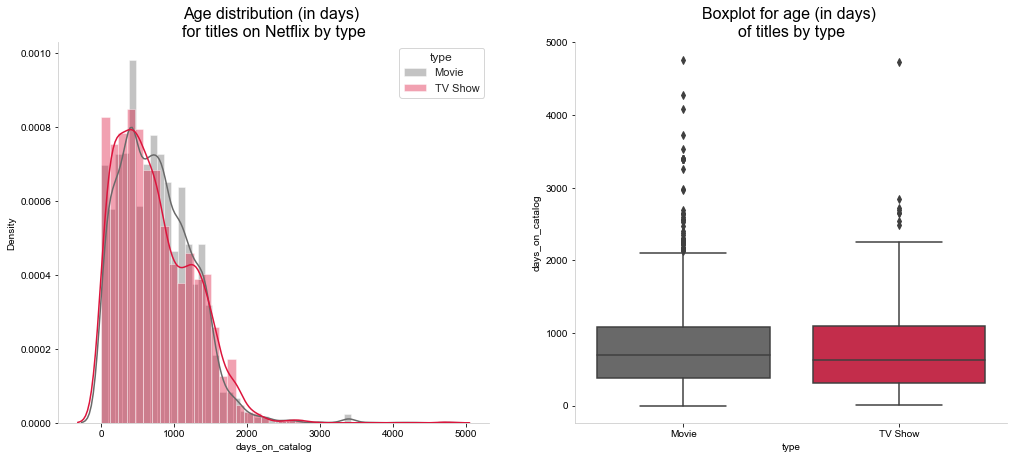

In [12]:
# Setting snapshot date
df_prep['catalog_date'] = df_prep['date_added_dt'].max()

# Computing deltas
df_prep['days_on_catalog'] = (df_prep['catalog_date'] - df_prep['date_added_dt']).dt.days
df_prep['months_on_catalog'] = (df_prep['days_on_catalog'] / 30)
df_prep['years_on_catalog'] = (df_prep['days_on_catalog'] / 365)

# Creating figure and plotting statistical analysis
colors = ['dimgrey', 'crimson']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))
plot_distplot(df=df_prep, col='days_on_catalog', hue='type', ax=axs[0], color_list=colors,
              title='Age distribution (in days) \nfor titles on Netflix by type')
plot_distplot(df=df_prep, col='days_on_catalog', hue='type', ax=axs[1], palette=colors, kind='box',
              title='Boxplot for age (in days) \nof titles by type')

The age distribution of titles on the catalog are similar between movies and TV shows. One thing that can be pointed out is that movies are usually older than TV shows in terms of duration on catalog. We can see this by the boxtplot on the right where we have some outliers indicating really old movies (the median also reflects this behavior).

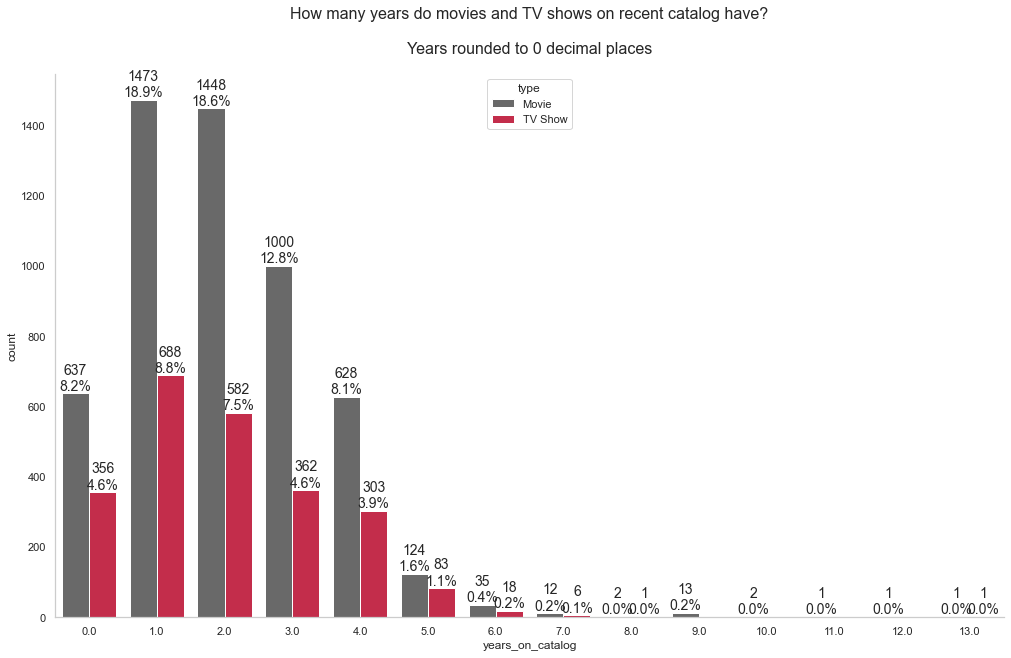

In [13]:
df_prep['years_on_catalog'] = round(df_prep['years_on_catalog'], 0)
plot_countplot(df=df_prep, col='years_on_catalog', hue='type', figsize=(17, 10), palette=colors,
               title='How many years do movies and TV shows on recent catalog have?\n\nYears rounded to 0 decimal places')

After extracting an age information of the data, many things can be explored. The cells bellow brings us a vision of the top 5 oldest and newst movies and TV shows. Let's see if we are enjoying Netflix the right way!

___
* **_Top 5 movies with most days on catalog_**
___

In [14]:
# Top 5 oldest movies
cols = ['type', 'title', 'country', 'date_added', 'release_year', 'duration']
print(f'Top 5 movies with most days on catalog')
df_prep.query('type == "Movie"').sort_values(by='days_on_catalog', ascending=False).head().loc[:, cols]

Top 5 movies with most days on catalog


,type,title,country,date_added,release_year,duration
7113,Movie,To and From New York,United States,"January 1, 2008",2006,81 min
3248,Movie,Just Another Love Story,Denmark,"May 5, 2009",2007,104 min
5765,Movie,Splatter,United States,"November 18, 2009",2009,29 min
3840,Movie,Mad Ron's Prevues from Hell,United States,"November 1, 2010",1987,84 min
2041,Movie,Even the Rain,"Spain, Mexico, France","May 17, 2011",2010,103 min


___
* **_Top 5 movies recently added on catalog_**
___

In [15]:
# Top 5 newest movies
print(f'Top 5 movies recently added on catalog')
df_prep.query('type == "Movie"').sort_values(by='days_on_catalog', ascending=True).head().loc[:, cols]

Top 5 movies recently added on catalog


,type,title,country,date_added,release_year,duration
205,Movie,A Monster Calls,"United Kingdom, Spain, United States","January 16, 2021",2016,108 min
5059,Movie,Radium Girls,United States,"January 16, 2021",2018,103 min
1673,Movie,Death of Me,"United States, Thailand","January 16, 2021",2020,94 min
7644,Movie,Wish You,NaN,"January 15, 2021",2021,102 min
7220,Movie,Tribhanga - Tedhi Medhi Crazy,NaN,"January 15, 2021",2021,96 min


___
* **_Top 5 TV shows with most days on catalog_**
___

In [16]:
# Top 5 oldest movies
print(f'Top 5 TV Shows with most days on catalog')
df_prep.query('type == "TV Show"').sort_values(by='days_on_catalog', ascending=False).head().loc[:, cols]

Top 5 TV Shows with most days on catalog


,type,title,country,date_added,release_year,duration
1765,TV Show,Dinner for Five,United States,"February 4, 2008",2007,1 Season
3098,TV Show,Jack Taylor,"United States, Ireland","March 31, 2013",2016,1 Season
1089,TV Show,Breaking Bad,United States,"August 2, 2013",2013,5 Seasons
6056,TV Show,The 4400,"United States, United Kingdom","September 1, 2013",2007,4 Seasons
2503,TV Show,Gossip Girl,United States,"October 8, 2013",2012,6 Seasons


___
* **_Top 5 TV shows recently added on catalog_**
___

In [30]:
df_prep.release_year.value_counts().sort_values(ascending=False).head(10)

2018    1121
2017    1012
2019     996
2016     882
2020     868
2015     541
2014     334
2013     267
2012     219
2010     173
Name: release_year, dtype: int64

In [17]:
# Top 5 newest movies
print(f'Top 5 TV shows recently added on catalog')
df_prep.query('type == "TV Show"').sort_values(by='days_on_catalog', ascending=True).head().loc[:, cols]

Top 5 TV shows recently added on catalog


,type,title,country,date_added,release_year,duration
6634,TV Show,The Magicians,"United States, Canada","January 15, 2021",2020,5 Seasons
2699,TV Show,Henry Danger,United States,"January 15, 2021",2016,3 Seasons
980,TV Show,Bling Empire,NaN,"January 15, 2021",2021,1 Season
1780,TV Show,Disenchantment,United States,"January 15, 2021",2021,3 Seasons
1222,TV Show,Carmen Sandiego,United States,"January 15, 2021",2021,4 Seasons


<a id="3.3"></a>
<font color="dimgrey" size=+2.0><b>How Many People Compose the Cast and Who are Them?</b></font>



By looking at the top titles on the tables above, it raised a idea on also looking at the people who were part of the movies or TV shows. With this we are talking about directors and cast. Let's use the `cast` column for creating a list of cast for each line and counting how many people participated on the movie or TV show creation.

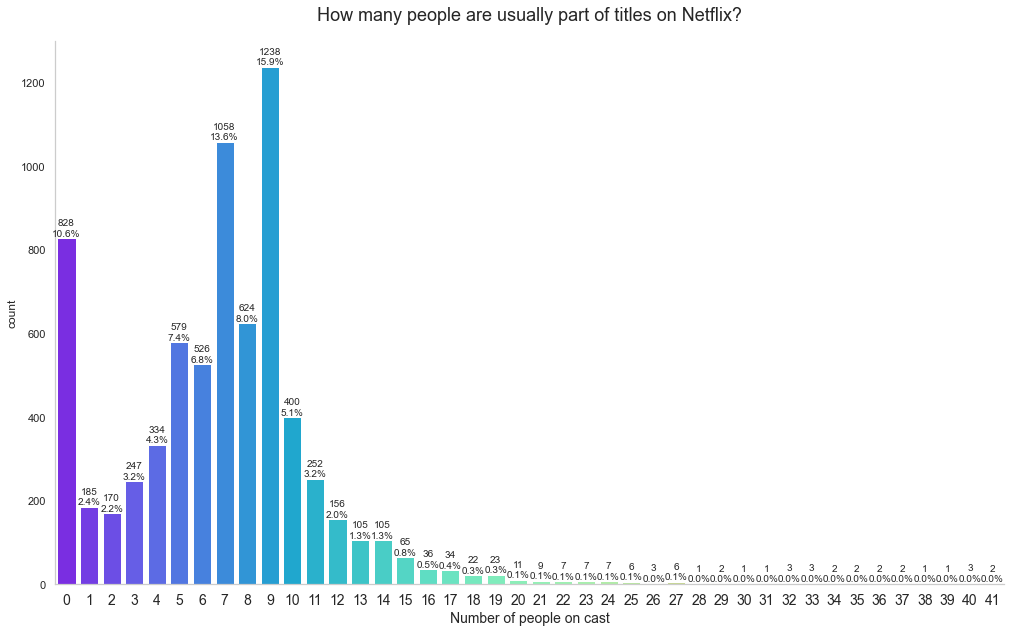

In [18]:
# Creating a function for extracting people on cast
def num_people_on_cast(cast_str, splitter=','):
    try:
        return int(len(cast_str.split(splitter)))
    except AttributeError as ae:
        return np.nan

# Extracting total people on cast
df_prep['num_people_on_cast'] = df_prep['cast'].apply(lambda x: num_people_on_cast(x))

# Plotting figure
fig, ax = plt.subplots(figsize=(17, 10))
plot_countplot(df=df_prep, col='num_people_on_cast', ax=ax, size_labels=10,
               title='How many people are usually part of titles on Netflix?', size_title=18)

# Customizing chart
ax.set_xticklabels(ax.get_xticks(), rotation=0)
ax.set_xlabel('Number of people on cast', size=14)
plt.xticks(fontsize=(14))
plt.show()

The countplot above shows a distribution of people on cast for titles on Netflix catalog. We can see that there are 1,238 titles with 9 people on cast and this is the marjority configuration. 

But how about actors and actresses? Who are they? Let's make a little change on our dataset and extract who appears most on Netflix catalog.

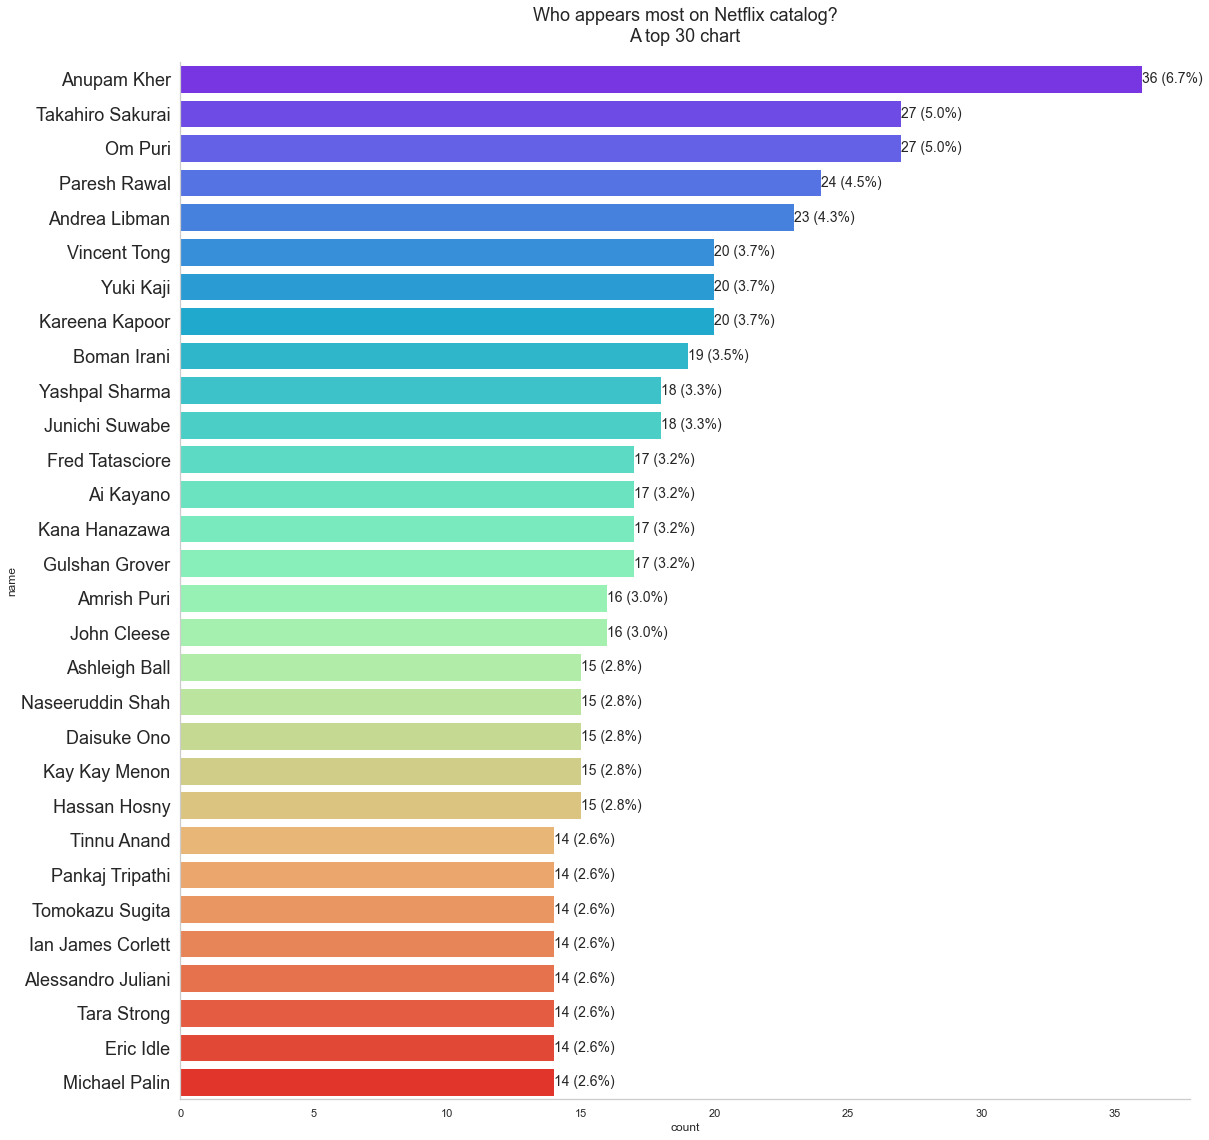

In [19]:
# Defining function for extracting individual names from cast list
def extract_list_from_string(cast_str, splitter=','):
    try:
        return [c.strip() for c in cast_str.split(splitter)]
    except AttributeError as ae:
        return np.nan

# Extracting actors and actresses
cast_list = extract_list_from_string(''.join(list(df_prep['cast'].fillna(' ').values)))
df_cast = pd.DataFrame(cast_list, columns=['name'])

# Counting appearence
plot_countplot(df=df_cast, col='name', top=30, order=True, orient='h', figsize=(17, 16),
               title='Who appears most on Netflix catalog?\nA top 30 chart', size_title=18)

# Customizing chart
plt.yticks(fontsize=(18))
plt.tight_layout()
plt.show()

Well, it seems that [Anupam Kher] is the actor who appears most considering the names on cast for all titles on Netflix catalog. Other common names includes [Takahiro Sakurai], [Om Puri], [Paresh Rawal], [Andrea Libman], [Kareena Kappor] and others.

Looking at the names on the chart includes actors, actresses, voice actors and voice actresses and everyone who ever made part of the movie or show. It would be nice to see the cast appearence for each type of tile (movies and TV shows). So the chart above will apply this analysis by counting people appearence only on movies (left - gray) and only on TV shows (right - red)

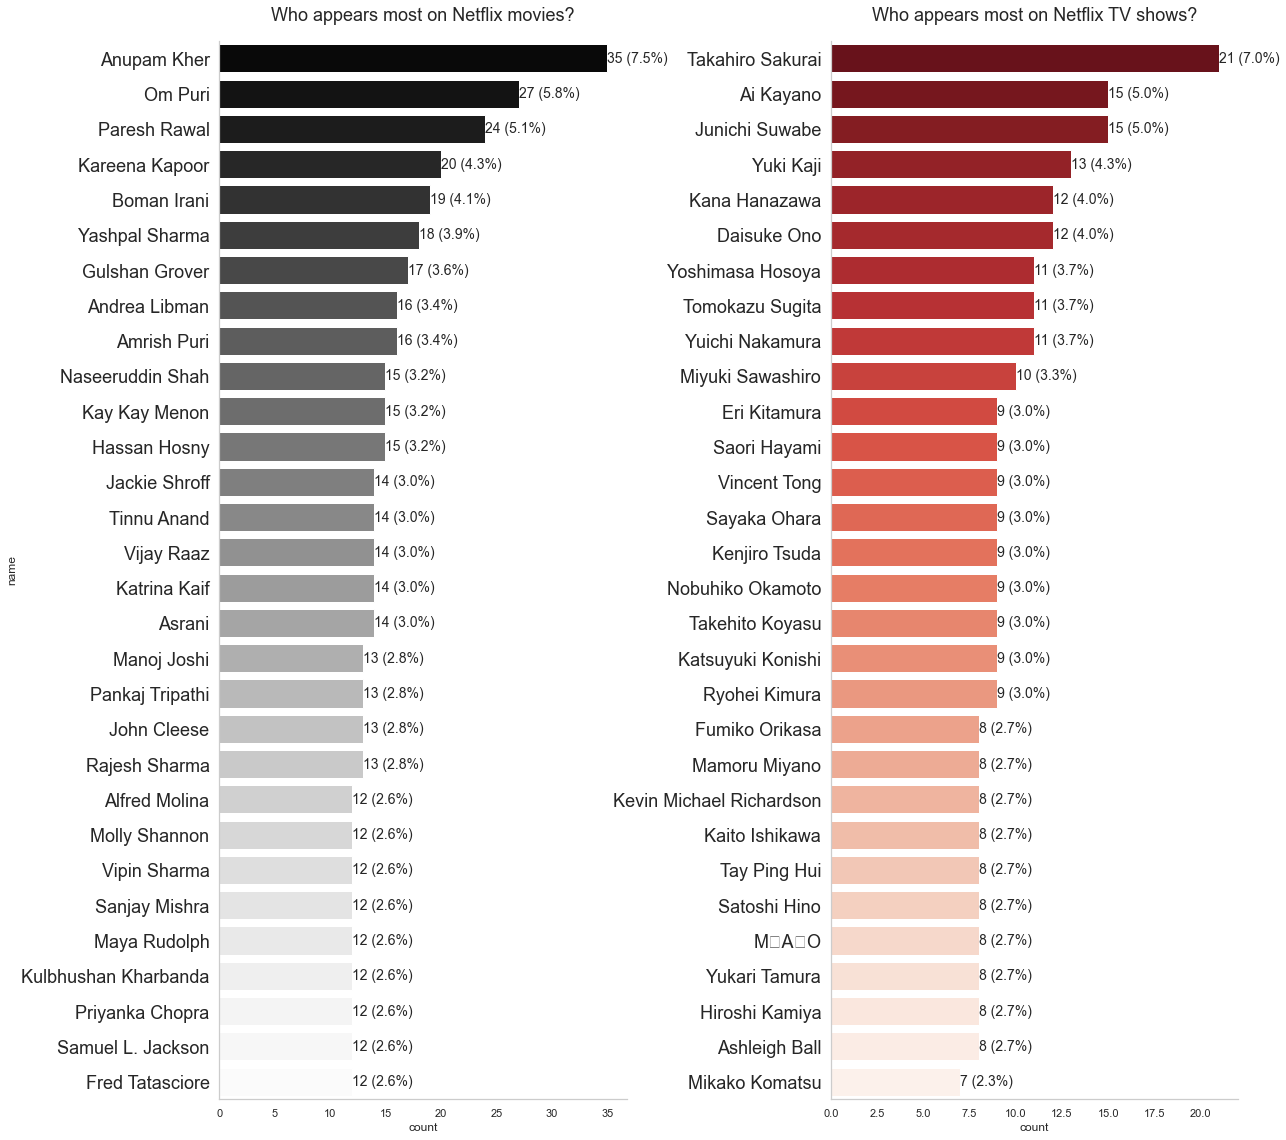

In [20]:
# Creating subsets for movies and TV shows
df_movies = df_prep.query('type == "Movie"')
df_tvs = df_prep.query('type == "TV Show"')

# Extracting actors and actresses
movies_cast_list = extract_list_from_string(''.join(list(df_movies['cast'].fillna(' ').values)))
df_cast_movies = pd.DataFrame(movies_cast_list, columns=['name'])
tvs_cast_list = extract_list_from_string(''.join(list(df_tvs['cast'].fillna(' ').values)))
df_cast_tvs = pd.DataFrame(tvs_cast_list, columns=['name'])

# Counting appearence
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(17, 16))

# Plotting appearence on movies and TV Shows
plot_countplot(df=df_cast_movies, col='name', top=30, order=True, orient='h', ax=axs[0],
               title='Who appears most on Netflix movies?', size_title=18, palette='Greys_r')
plot_countplot(df=df_cast_tvs, col='name', top=30, order=True, orient='h', ax=axs[1],
               title='Who appears most on Netflix TV shows?', size_title=18, palette='Reds_r')

# Tighting layout
plt.tight_layout()
plt.setp(axs[0].get_yticklabels(), fontsize=18)
plt.setp(axs[1].get_yticklabels(), fontsize=18)
axs[1].set_ylabel('')
plt.show()

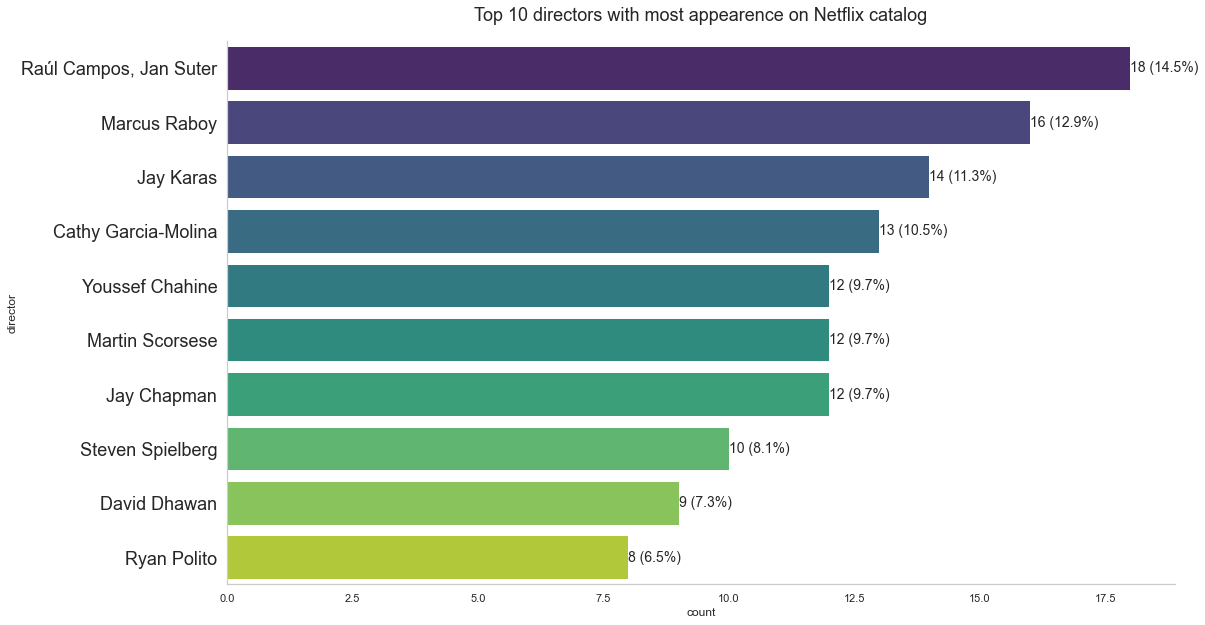

In [21]:
# Top 10 directors
plot_countplot(df=df, col='director', top=10, orient='h', order=True, figsize=(17, 10), palette='viridis',
               title='Top 10 directors with most appearence on Netflix catalog', size_title=18)
plt.yticks(fontsize=(18))
plt.show()

We can see some really known names on the top 10 list. If you don't recognize any of them, you should use more Netflix service :D

<a id="3.4"></a>
<font color="dimgrey" size=+2.0><b>From Where Netlix's Products Come From?</b></font>



On this topic, let's explore the column `country` which says where the title comes from. It will be possible to visualize Netflix catalog from a global perspective. In a first step, let's extract the correct information of country by looking at each individual country on the column, even if it's given by a string splitted by comma.

In [22]:
#  Function for extracting useful country info by its name
def get_country_info(col):
    try:
        cn_a2_code =  country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown'
    try:
        cn_a3_code =  country_name_to_country_alpha3(col)
    except:
        cn_a3_code = 'Unknown'
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown' 
    return (cn_a2_code, cn_a3_code, cn_continent)

# Defining geolocator and function for extracting coordinates

def get_geocode(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return (loc.latitude, loc.longitude)
    except:
        # Return missing value
        return np.nan
    
# Creating a dictionary of countries and geolocation (in case of API error)
country_dict = {'US': (39.7837304, -100.4458825),
                 'IN': (22.3511148, 78.6677428),
                 'GB': (54.7023545, -3.2765753),
                 'Unknown': (51.1461391, 12.233285),
                 'CA': (61.0666922, -107.991707),
                 'FR': (46.603354, 1.8883335),
                 'JP': (36.5748441, 139.2394179),
                 'ES': (39.3260685, -4.8379791),
                 'KR': (36.638392, 127.6961188),
                 'DE': (51.0834196, 10.4234469),
                 'MX': (22.5000485, -100.0000375),
                 'CN': (35.000074, 104.999927),
                 'AU': (-24.7761086, 134.755),
                 'EG': (26.2540493, 29.2675469),
                 'TR': (38.9597594, 34.9249653),
                 'HK': (22.2793278, 114.1628131),
                 'IT': (42.6384261, 12.674297),
                 'BR': (-10.3333333, -53.2),
                 'TW': (23.9739374, 120.9820179),
                 'BE': (50.6402809, 4.6667145),
                 'AR': (-34.9964963, -64.9672817),
                 'ID': (-2.4833826, 117.8902853),
                 'PH': (12.7503486, 122.7312101),
                 'NG': (9.6000359, 7.9999721),
                 'TH': (14.8971921, 100.83273),
                 'ZA': (-28.8166236, 24.991639),
                 'CO': (2.8894434, -73.783892),
                 'NL': (52.5001698, 5.7480821),
                 'DK': (55.670249, 10.3333283),
                 'IE': (52.865196, -7.9794599),
                 'SE': (59.6749712, 14.5208584),
                 'SG': (1.357107, 103.8194992),
                 'PL': (52.215933, 19.134422),
                 'AE': (24.0002488, 53.9994829),
                 'NO': (60.5000209, 9.0999715),
                 'NZ': (-41.5000831, 172.8344077),
                 'RU': (64.6863136, 97.7453061),
                 'IL': (31.5313113, 34.8667654),
                 'CL': (-31.7613365, -71.3187697),
                 'LB': (33.8750629, 35.843409),
                 'MY': (4.5693754, 102.2656823),
                 'PK': (30.3308401, 71.247499),
                 'CZ': (49.8167003, 15.4749544),
                 'CH': (46.813331250000005, 8.444947437939408),
                 'UY': (-32.8755548, -56.0201525),
                 'RO': (45.9852129, 24.6859225),
                 'FI': (63.2467777, 25.9209164),
                 'AT': (47.2, 13.2),
                 'LU': (49.8158683, 6.1296751),
                 'PE': (-6.8699697, -75.0458515),
                 'SA': (25.6242618, 42.3528328),
                 'GR': (38.9953683, 21.9877132),
                 'HU': (47.1817585, 19.5060937),
                 'IS': (64.9841821, -18.1059013),
                 'BG': (42.6073975, 25.4856617),
                 'JO': (31.1667049, 36.941628),
                 'RS': (44.1534121, 20.55144),
                 'KW': (29.2733964, 47.4979476),
                 'QA': (25.3336984, 51.2295295),
                 'MA': (31.1728205, -7.3362482),
                 'KH': (13.5066394, 104.869423),
                 'KE': (1.4419683, 38.4313975),
                 'VN': (13.2904027, 108.4265113),
                 'PT': (40.0332629, -7.8896263),
                 'GH': (7.8573710000000005, -1.0840975468820433),
                 'HR': (45.5643442, 17.0118954),
                 'IR': (32.6475314, 54.5643516),
                 'BD': (24.4768783, 90.2932426),
                 'ZW': (-19.01688, 29.35365015971339),
                 'SN': (14.46517725, -14.765340959100413),
                 'MT': (35.8885993, 14.4476911),
                 'SI': (45.8133113, 14.4808369),
                 'VE': (8.0018709, -66.1109318),
                 'UA': (49.4871968, 31.2718321),
                 'KY': (19.703182249999998, -79.9174627243246),
                 'GT': (15.6356088, -89.8988087),
                 'NA': (-23.2335499, 17.3231107),
                 'GE': (32.3293809, -83.1137366),
                 'NP': (28.1083929, 84.0917139),
                 'IQ': (33.0955793, 44.1749775),
                 'DZ': (28.0000272, 2.9999825),
                 'BM': (32.3018217, -64.7603583),
                 'AF': (33.7680065, 66.2385139),
                 'AL': (41.000028, 19.9999619),
                 'LK': (7.5554942, 80.7137847),
                 'SD': (14.5844444, 29.4917691),
                 'BW': (-23.1681782, 24.5928742),
                 'AO': (-11.8775768, 17.5691241),
                 'SY': (34.6401861, 39.0494106),
                 'BY': (53.4250605, 27.6971358),
                 'BS': (24.7736546, -78.0000547),
                 'AZ': (40.3936294, 47.7872508),
                 'SO': (8.3676771, 49.083416),
                 'AM': (40.7696272, 44.6736646),
                 'UG': (1.5333554, 32.2166578),
                 'JM': (18.1850507, -77.3947693),
                 'SK': (48.7411522, 19.4528646),
                 'NI': (12.6090157, -85.2936911),
                 'KZ': (47.2286086, 65.2093197),
                 'LV': (56.8406494, 24.7537645),
                 'LI': (47.1416307, 9.5531527),
                 'MW': (-13.2687204, 33.9301963),
                 'MU': (-20.2759451, 57.5703566),
                 'MN': (46.8250388, 103.8499736),
                 'ME': (42.9868853, 19.5180992),
                 'PA': (8.559559, -81.1308434),
                 'WS': (-13.7693895, -172.1200508),
                 'EC': (-1.3397668, -79.3666965),
                 'DO': (19.28131815, -70.035906834967),
                 'PY': (-23.3165935, -58.1693445),
                 'PR': (18.2214149, -66.41328179513847),
                 'CY': (34.9823018, 33.1451285),
                 'CU': (23.0131338, -80.8328748),
                 'LT': (55.3500003, 23.7499997)}

Well, let's apply some code for using the country information on our source dataset grouping the number of titles that appear for each country. After that, we will apply some functions for extracting geolocation information from those countries, like codes in different systems (alpha2 and alpha3) and also coordinates (latitude and longitude).

In [23]:
# Extracting number of titles references for each country
country_list = extract_list_from_string(','.join(list(df['country'].fillna('Unknown').values)))
df_countries = pd.DataFrame(pd.DataFrame(country_list, columns=['country_name']).value_counts())
df_countries.reset_index(inplace=True)
df_countries.columns = ['country_name', 'num_titles']

# Joining with country codes from pycountry-convert
df_countries['codes'] = df_countries['country_name'].apply(lambda x: get_country_info(x))
df_countries['country_a2'] = df_countries['codes'].apply(lambda x: x[0])
df_countries['country_a3'] = df_countries['codes'].apply(lambda x: x[1])
df_countries['continent'] = df_countries['codes'].apply(lambda x: x[2])

# Extracting latitude and longitude coordinates from geopy
#df_countries['geolocate'] = df_countries['country_name'].apply(lambda x: geolocate(x))

# Extracting latitude and longitude coordinates from countries dictionary already saved
df_countries['geolocate'] = df_countries['country_a2'].map(country_dict)
df_countries['latitude'] = df_countries['geolocate'].apply(lambda x: x[0])
df_countries['longitude'] = df_countries['geolocate'].apply(lambda x: x[1])

# Extracting latitude and longitude coordinates from countries dictiona
df_countries.head(10)

,country_name,num_titles,codes,country_a2,country_a3,continent,geolocate,latitude,longitude
0,United States,3297,"(US, USA, NA)",US,USA,NA,"(39.7837304, -100.4458825)",39.783730,-100.445882
1,India,990,"(IN, IND, AS)",IN,IND,AS,"(22.3511148, 78.6677428)",22.351115,78.667743
2,United Kingdom,723,"(GB, GBR, EU)",GB,GBR,EU,"(54.7023545, -3.2765753)",54.702354,-3.276575
3,Unknown,507,"(Unknown, Unknown, Unknown)",Unknown,Unknown,Unknown,"(51.1461391, 12.233285)",51.146139,12.233285
4,Canada,412,"(CA, CAN, NA)",CA,CAN,NA,"(61.0666922, -107.991707)",61.066692,-107.991707
5,France,349,"(FR, FRA, EU)",FR,FRA,EU,"(46.603354, 1.8883335)",46.603354,1.888334
6,Japan,287,"(JP, JPN, AS)",JP,JPN,AS,"(36.5748441, 139.2394179)",36.574844,139.239418
7,Spain,215,"(ES, ESP, EU)",ES,ESP,EU,"(39.3260685, -4.8379791)",39.326068,-4.837979
8,South Korea,212,"(KR, KOR, AS)",KR,KOR,AS,"(36.638392, 127.6961188)",36.638392,127.696119
9,Germany,199,"(DE, DEU, EU)",DE,DEU,EU,"(51.0834196, 10.4234469)",51.083420,10.423447


After extracting all informations needed for working with countries, let's plot a map using `folium` library that can answear below question: how titles in Netflix catalog are distributed around the world? With the dataset above we could see the numbers in a table format (the DataFrame was already sorted by `num_titles`), but with maps we can visually see this answear in a more beautiful format.

In [31]:
#from folium.plugins import FastMarkerCluster

# Extracting locations
locations = list(df_countries['geolocate'])
df_countries['norm_titles_radius'] = np.log1p(df_countries['num_titles'])

# Creating a map using folium
map1 = folium.Map(location=[35, -0], zoom_start=2.0, tiles='cartodbpositron')

# Plugin: FastMarkerCluster
#FastMarkerCluster(data=locations).add_to(map1)

# Iterating over each row
for i in range(len(df_countries)):
    loc = df_countries['geolocate'][i]
    country = df_countries['country_name'][i]
    titles = df_countries['num_titles'][i]
    tooltip = f'<b><i>Country:</b></i> {country}\n<b><i>Titles:</b></i> {titles}'
    
    radius = df_countries['norm_titles_radius'][i] * 2
    
    # Adding CircleMarker plugin
    folium.CircleMarker(location=loc, radius=radius, color='crimson', 
                        popup=tooltip, fill=True).add_to(map1)

map1

There is another good format to see how is Netflix around the world: by using Choropleth maps.

In [32]:
# Defining a style function for Choropleth
def style_function(feature):
    """
    Customize maps
    """
    return {
        'fillColor': '#ffaf00',
        'color': 'grey',
        'weight': 1.0,
        'dashArray': '5, 5'
    }

# Defining a highlight function for Choropleth
def highlight_function(feature):
    """
    Customize maps
    """
    return {
        'fillColor': '#ffaf00',
        'color': 'white',
        'weight': 1.5,
        'dashArray': '5, 5'
    }

In [33]:
# Extracting a world map model from github
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
world_geo = f'{url}/world-countries.json'
json_data = gpd.read_file(f'{url}/world-countries.json')

# Joining data for custom tooltips
global_data = json_data.merge(df_countries, how='left', left_on='id', right_on='country_a3').fillna(0)
global_data = global_data.loc[:, ['name', 'num_titles', 'geometry']]

# Creating a map using folium
m = folium.Map(
    location=[35, 0], 
    zoom_start=1.50,
    tiles='openstreetmap'
)

# Choropleth map
folium.Choropleth(
    geo_data=world_geo,
    name='Netflix Around the World',
    data=df_countries.query('country_a3 != "Unknown"'),
    columns=['country_a3', 'norm_titles_radius'],
    key_on='feature.id',
    fill_color='Reds',
    fill_opacity=.9,
    line_opacity=.7,
    nan_fill_color='white',
    nan_fill_opacity=0.9,
    legend_name='Log of Number of Titles'
).add_to(m)

# Adding a fullscreen button plugin
Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True
).add_to(m)

# Customizing tooltips
folium.GeoJson(
    global_data,
    style_function=style_function,
    highlight_function=highlight_function,
    tooltip=folium.GeoJsonTooltip(fields=['name', 'num_titles'],
                                  aliases=['Country:', 'Number of Titles:'],
                                  labels=True,
                                  sticky=True)
).add_to(m)
    
m

Well, using maps is a good way to visualize the spread of Netflix around the world in termos of titles added on the streaming platform. 

<a id="3.5"></a>
<font color="dimgrey" size=+2.0><b>Movies and TV Shows Duration (Minutes and Seasons)</b></font>



Let's extract information on `duration` column for movies and TV shows for visualizing some patterns on Netflix catalog. The idea is to split the source data on this column in order to extract the numerical value and the scale. Looking at the data, it's possible to see that we have different scales for movies (minutes) and TV shows (seasons) and, because of this, we will plot two different charts for looking at titles duration for this two types.

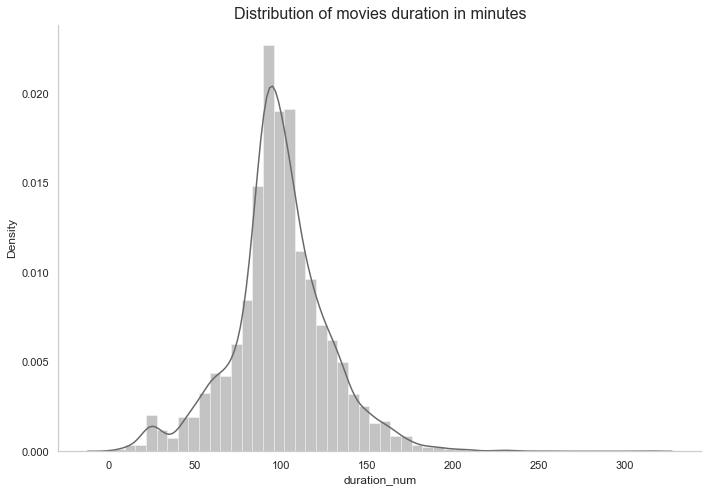

In [34]:
# Extracting the age of the title in years
df_prep['title_age_years'] = datetime.now().year - df_prep['release_year']

# Extracting title's duration information
df_prep['duration_num'] = df_prep['duration'].apply(lambda x: int(x.split(' ')[0]))
df_prep['duration_scale'] = df_prep['duration'].apply(lambda x: x.split(' ')[-1].strip())

# Fixing duration scale name
df_prep['duration_scale'] = df_prep['duration_scale'].apply(lambda x: 'Season' if x in ('Season', 'Seasons') else x)

# Filtering movies and tvshows
movies = df_prep.query('is_movie == 1')
tvshows = df_prep.query('is_tvshow == 1')

# Plotting duration on movies
#fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(17, 15))
plot_distplot(df=movies, col='duration_num', color='dimgrey',
              title='Distribution of movies duration in minutes')
# plot_countplot(df=tvshows, col='duration_num', ax=axs[1], color='crimson', size_labels=10,
#                title='TV Shows countplot by duration in seasons')

plt.tight_layout()
plt.show()

___
* **_Top 5 movies with highest duration_**
___

In [35]:
# Sorting movies
movies.sort_values(by='duration_num', ascending=False).head().loc[:, cols]

,type,title,country,date_added,release_year,duration
957,Movie,Black Mirror: Bandersnatch,United States,"December 28, 2018",2018,312 min
6850,Movie,The School of Mischief,Egypt,"May 21, 2020",1973,253 min
4490,Movie,No Longer kids,Egypt,"May 21, 2020",1979,237 min
3694,Movie,Lock Your Girls In,NaN,"May 21, 2020",1982,233 min
5108,Movie,Raya and Sakina,NaN,"May 21, 2020",1984,230 min


___
* **_Top 5 TV shows with most seasons_**
___

In [ ]:
# Sorting movies
tvshows.sort_values(by='duration_num', ascending=False).head().loc[:, cols]

In [ ]:
# Extracting top 10 countries with most titles on Netflix
top_countries = df_prep['country'].value_counts().index[:10]
df_countries = df_prep.query('country in (@top_countries)')

# Defining figure and axis
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(17, 15))

# Plotting average duration for movies of top 10 countries
plot_aggregation(df=df_countries.query('type == "Movie"'), group_col='country', palette='Greys_r',
                 value_col='duration_num', aggreg='mean', ax=axs[0], order=top_countries, size_title=20,
                 title='Mean duration from movies of the top 10 countries \nwith most titles on Netflix')

# Plotting average number os seasons for TV shows of top 10 countries
plot_aggregation(df=df_countries.query('type == "TV Show"'), group_col='country', palette='Reds_r',
                 value_col='duration_num', aggreg='mean', ax=axs[1], order=top_countries, size_title=20,
                 title='Average number of seasons from TV shows of the top 10 countries\n with most titles on Netflix')

# Tighting layout
plt.tight_layout()
plt.setp(axs[0].get_xticklabels(), fontsize=18)
plt.setp(axs[1].get_xticklabels(), fontsize=18)
axs[0].set_xlabel('')
axs[0].set_ylabel('Duration in minutes')
axs[1].set_ylabel('Duration in #Seasons')
plt.show()

It seems like India is the country the provides movies to Netflix with highest duration (at the same time, the average number of seasons of Indian TV shows are quite low). On the other hand, we can see that Canada usually provides TV shows to Netflix with a high number of seasons in average.

Let's go ahead with our exploration and take a look at new questions to be answeared with data.

<a id="3.6"></a>
<font color="dimgrey" size=+2.0><b>Dramas or Comedies? How Are Netflix Titles Listed In?</b></font>



On the road for gathering insights from Netflix titles dataset, let's take a deep dive on the `listed_in` column to extract some trends or patterns on how the catalog are distributed in termos of movies and TV shows types. There are more dramas than thrillers? How about comedy and cult movies?

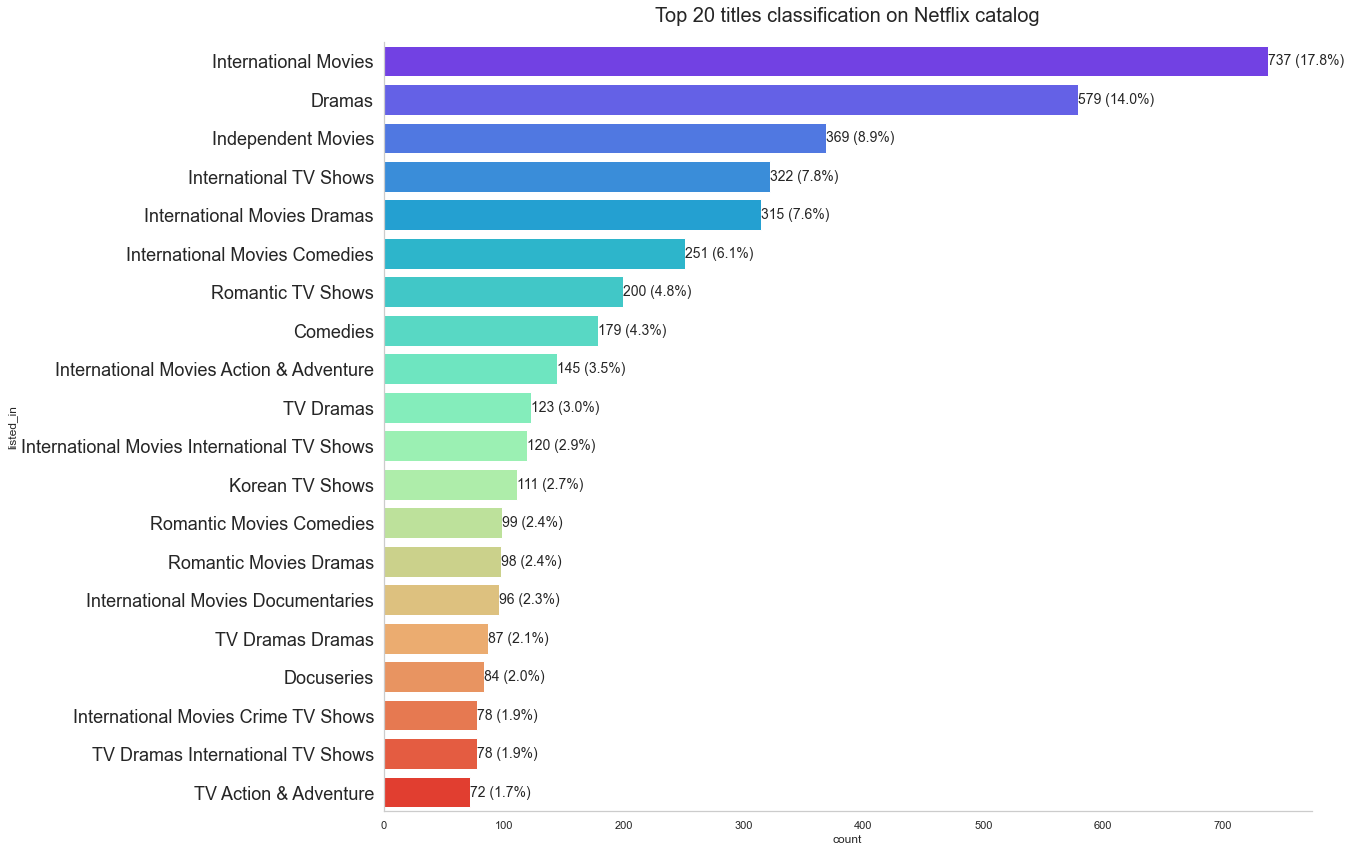

In [36]:
# Extracting a list for titles classification
listed_titles = pd.DataFrame(extract_list_from_string(' '.join(list(df_prep['listed_in'].values))))
listed_titles.columns = ['listed_in']

# Plotting a bar chart with top N types
plot_countplot(df=listed_titles, col='listed_in', orient='h', top=20, order=True, figsize=(17, 12),
               title='Top 20 titles classification on Netflix catalog', size_title=20)

plt.tight_layout()
plt.yticks(fontsize=(18))
plt.show()

Ok, we can see that *International Movies*, *Dramas* and *Independent Movies* are the top 3 flavours of titles on Netflix. But one thing must be said: when looking at the `listed_in` column, it was possible to look at some "typos" on string entries that compose the attribute. The thing is that not all `listed_in` strings are delimited by comma, for example. Some of them were delimitted by space and that's why we can see things like *International Movies Crime TV Shows* in one category and not at least three different ones (maybe the correct was International Movies, Crime and TV Shows as separated categories).

<a id="3.7"></a>
<font color="dimgrey" size=+2.0><b>Can Netflix Draw our Attention Just by Titles Description?</b></font>



In one of the most exciting analysis, we can go deeper at the `description` column of the dataset to extract some text trends on how Netflix uses this feature for drawing the public attention. For this, let's use some functions for extracting information from raw text presenting on our dataset.

In [37]:
# !pip install wordcloud
# !pip install nltk

In [38]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\powel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [39]:
# Importing libraries
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from PIL import Image
import requests

# Function for counting ngrams
def ngrams_count(corpus, ngram_range=(1, 1), n=-1, cached_stopwords=stopwords.words('english')):
    
    
    # Using CountVectorizer to build a bag of words using the given corpus
    vectorizer = CountVectorizer(stop_words=cached_stopwords, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    
    # Summing words and generating a frequency list
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    total_list = words_freq[:n]
    
    # Returning a DataFrame with the ngrams count
    return pd.DataFrame(total_list, columns=['ngram', 'count'])

# Building a pre configured wordcloud object
def generate_wordcloud(corpus, ngram_range=(1, 1), n=-1, cached_stopwords=stopwords.words('english'),
                       **kwargs):
    
    
    # Generating a DataFrame with ngrams count
    df_count = ngrams_count(corpus=corpus, ngram_range=ngram_range, n=n, 
                            cached_stopwords=cached_stopwords)
    
    # Transforming the ngram count into a dictionary
    words_dict = {w: c for w, c in df_count.loc[:, ['ngram', 'count']].values}
    
    # Extracting kwargs for generating a wordcloud
    width = kwargs['width'] if 'width' in kwargs else 1280
    height = kwargs['height'] if 'height' in kwargs else 720
    random_state = kwargs['random_state'] if 'random_state' in kwargs else 42
    colormap = kwargs['colormap'] if 'colormap' in kwargs else 'viridis'
    background_color = kwargs['background_color'] if 'background_color' in kwargs else 'white'
    
    # Creating a mask if applicable
    mask = kwargs['mask'] if 'mask' in kwargs else None
    try:
        if type(mask) == str and mask is not None:
            # Requesting the image url using requests and transforming it using PIL
            img = Image.open(requests.get(mask, stream=True).raw)
            mask_array = np.array(img)
            
            # If mask array is a 3-dimensional array, transformes it into a 2-dimensional
            if len(mask_array.shape) == 3:
                mask_array = mask_array[:, :, -1]
            
            # Creating a transformarion mask and changing pixels on it
            transf_mask = np.ndarray((mask_array.shape[0], mask_array.shape[1]), np.int32)
            for i in range(len(mask_array)):
                transf_mask[i] = [255 if px == 0 else 0 for px in mask_array[i]]

        # If mask argument is already given as an array
        else:
            transf_mask = mask
            
    except Exception as e:
        # Error on requesting or preparing the mask - wordcloud will be generated without it
        print(f'Error on requesting or preparing mask. WordCloud will be generated without mask')
        transf_mask = None
        
    
    # Generating wordcloud
    wordcloud = WordCloud(width=width, height=height, random_state=random_state, colormap=colormap, 
                          background_color=background_color, mask=transf_mask).generate_from_frequencies(words_dict)
    
    return wordcloud

# Plotting a custom wordcloud
def plot_wordcloud(corpus, ngram_range=(1, 1), n=-1, cached_stopwords=stopwords.words('english'),
                   **kwargs):
    
    # Extracting kwargs for generating a wordcloud
    width = kwargs['width'] if 'width' in kwargs else 1280
    height = kwargs['height'] if 'height' in kwargs else 720
    random_state = kwargs['random_state'] if 'random_state' in kwargs else 42
    colormap = kwargs['colormap'] if 'colormap' in kwargs else 'viridis'
    background_color = kwargs['background_color'] if 'background_color' in kwargs else 'white'
    mask = kwargs['mask'] if 'mask' in kwargs else None
    
    # Generating a pre configured wordcloud
    wordcloud = generate_wordcloud(corpus=corpus, ngram_range=ngram_range, n=n, 
                                   cached_stopwords=cached_stopwords, width=width, height=height,
                                   random_state=random_state, colormap=colormap, 
                                   background_color=background_color, mask=mask)
    
    # Extracting kwargs for figure plotting
    figsize = kwargs['figsize'] if 'figsize' in kwargs else (20, 17)
    ax = kwargs['ax'] if 'ax' in kwargs else None
    title = kwargs['title'] if 'title' in kwargs else f'Custom WordCloud Plot'
    size_title = kwargs['size_title'] if 'size_title' in kwargs else 18
    
    # Creating figure and plotting wordcloud
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)  
    ax.imshow(wordcloud)
    ax.axis('off')
    ax.set_title(title, size=size_title, pad=20)
    
    # Saving image if applicable
    if 'save' in kwargs and bool(kwargs['save']):
        output_path = kwargs['output_path'] if 'output_path' in kwargs else 'output/'
        img_name = kwargs['img_name'] if 'img_name' in kwargs else f'wordcloud.png'
        save_fig(fig=fig, output_path=output_path, img_name=img_name)

# Plotting a bar chart for a ngram count 
def plot_ngram_count(corpus, ngram_range=(1, 1), n=20, cached_stopwords=stopwords.words('english'),
                     **kwargs):
  
    
    # Generating a DataFrame with ngrams count
    df_count = ngrams_count(corpus=corpus, ngram_range=ngram_range, n=n, 
                            cached_stopwords=cached_stopwords)
    
    # Extracting kwargs for figure plotting
    x = kwargs['x'] if 'x' in kwargs else 'count'
    y = kwargs['y'] if 'y' in kwargs else 'ngram'
    figsize = kwargs['figsize'] if 'figsize' in kwargs else (20, 17)
    ax = kwargs['ax'] if 'ax' in kwargs else None
    palette = kwargs['palette'] if 'palette' in kwargs else 'viridis'
    title = kwargs['title'] if 'title' in kwargs else f'$n{ngram_range[0]}gram$ Count on Corpus'
    size_title = kwargs['size_title'] if 'size_title' in kwargs else 18
    
    # Creating figure and plotting wordcloud
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)  
    sns.barplot(x=x, y=y, data=df_count, ax=ax, palette=palette)
    ax.set_title(title, size=size_title, pad=20)
    
    # Customizing axis
    format_spines(ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.setp(ax.get_yticklabels(), fontsize=16)
    
    # Tighting layout
    plt.tight_layout()
    
    # Saving image if applicable
    if 'save' in kwargs and bool(kwargs['save']):
        output_path = kwargs['output_path'] if 'output_path' in kwargs else 'output/'
        img_name = kwargs['img_name'] if 'img_name' in kwargs else f'wordcloud.png'
        save_fig(fig=fig, output_path=output_path, img_name=img_name)

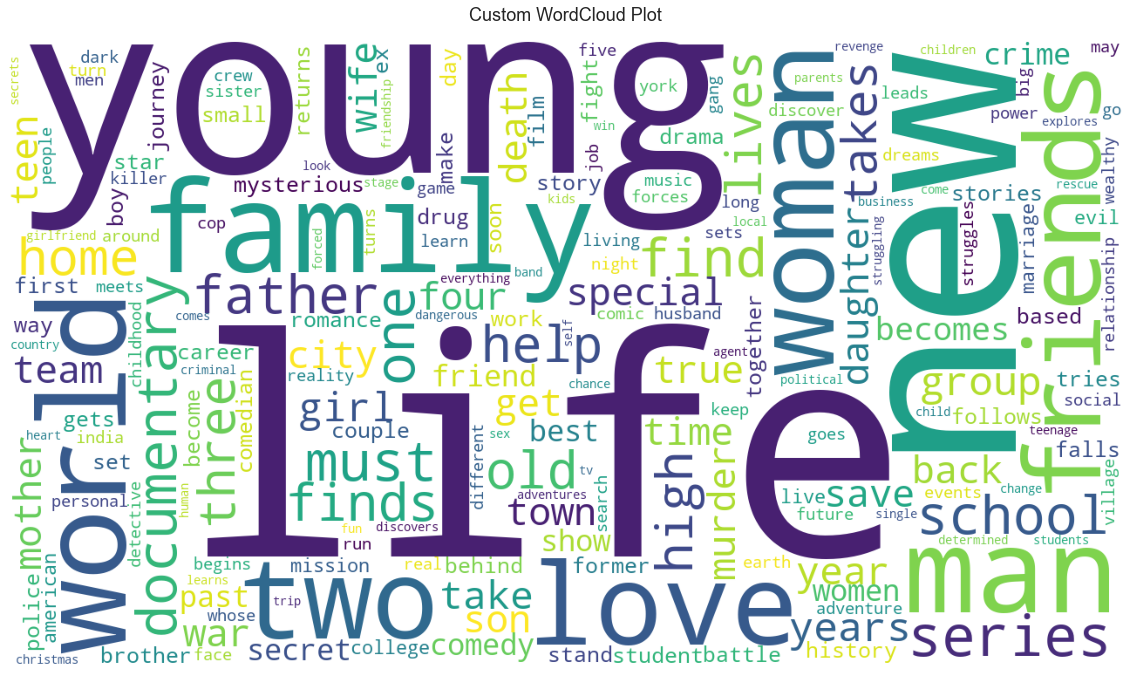

In [40]:
# Plotting a custom wordcloud
plot_wordcloud(df['description'])

Here we have a custom wordcloud chart for each world on `description` column. From user perspective, it can be said that these are all the words presented on Netflix titles description. Interesting how some words really pop up on eyes, like *life*, *young*, *new* and *love*.

On the continuous road to improvement, the `plot_wordcloud()` function can be used for plotting a custom wordcloud using a background mask. For this we can pass an image array (in case of reading a local image using PIL, for example) or even passing an internet image url string - the function handles the request by itself. Let's try to use the Netflix logo for customizing even more our WordCloud.

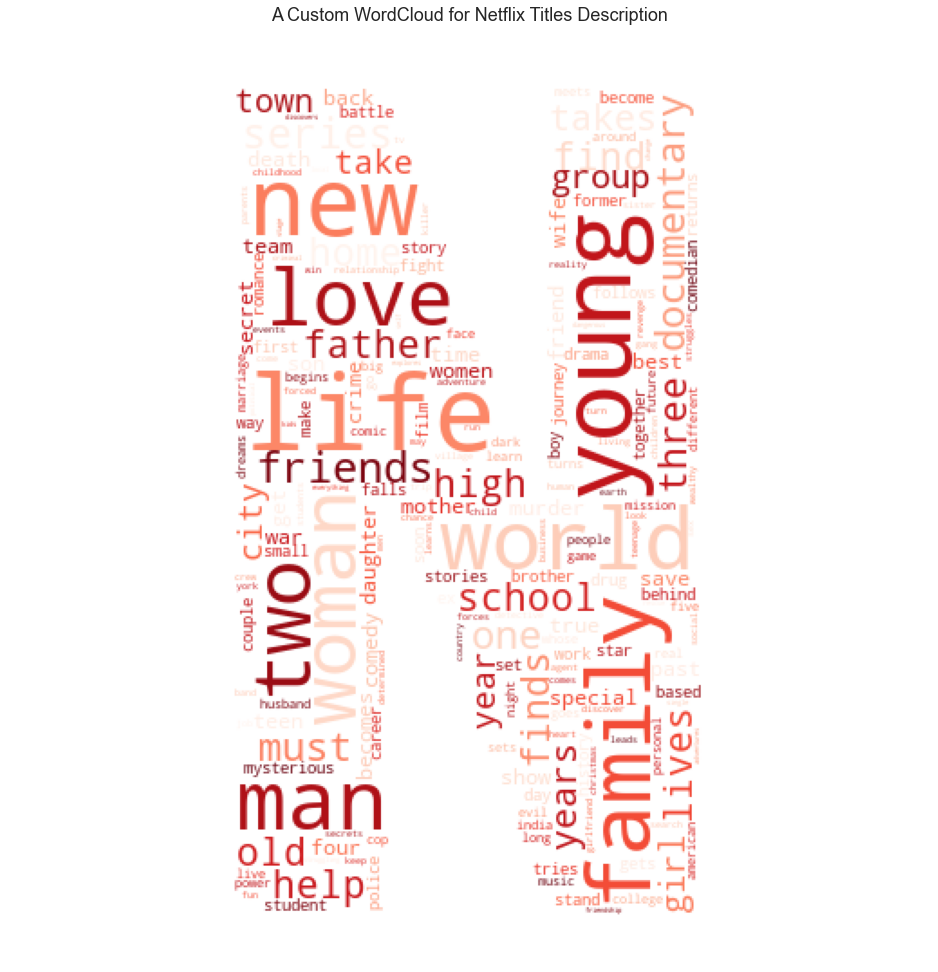

In [41]:
# Plotting a wordcloud with background image
url_mask = 'https://cdn4.iconfinder.com/data/icons/logos-and-brands-1/512/227_Netflix_logo-512.png'
plot_wordcloud(df['description'], mask=url_mask, colormap='Reds_r',
               title='A Custom WordCloud for Netflix Titles Description')

Awesome! Now still on text description analysis, let's use another excellent function for measuring a count for each word on the text corpus using *ngrams*. For this purpose, we will analyse two graphs: an unigram extraction and a bigram extraction.

With this we will see trends like how the words on titles descriptions are given alone (unigram) or in pairs (bigrams).

*Obs: I also tried to use trigrams, but it wasn't very effective, as long as there are no trends os patterns on titles descriptions with three words together*

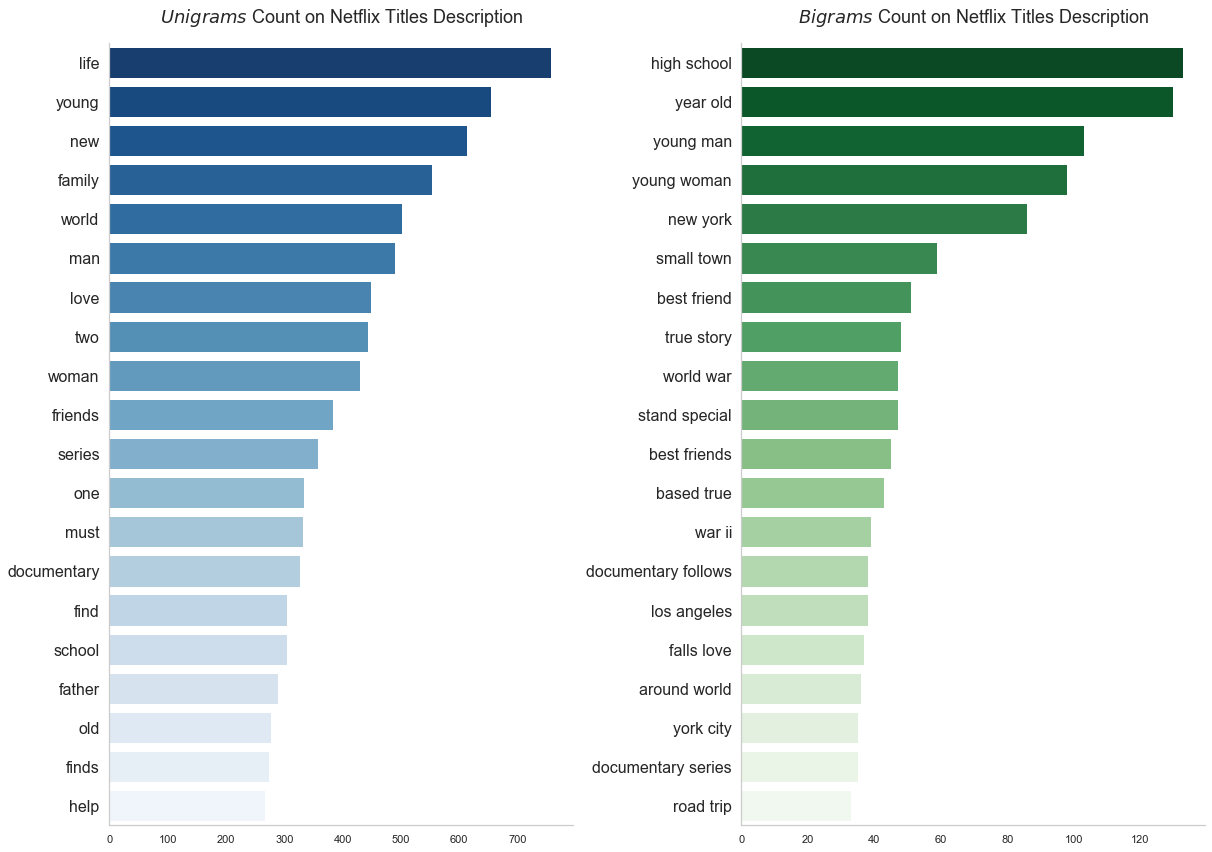

In [42]:
# Plotting ngrams charts
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(17, 12))
plot_ngram_count(df['description'], ngram_range=(1, 1), ax=axs[0], palette='Blues_r',
                 title='$Unigrams$ Count on Netflix Titles Description')
plot_ngram_count(df['description'], ngram_range=(2, 2), ax=axs[1], palette='Greens_r',
                 title='$Bigrams$ Count on Netflix Titles Description')

Well done! By looking at the wordclouds above, we have already seen word trends like *life* and *young*. But now looking at bigram chart on the rights, it seems there are a lot of titles on Netflix catalog talking about *high school*, *young man* or woman, *new york*, *small town*, *best friend* and other. Really nice insight!

<a id="3.8"></a>
<font color="dimgrey" size=+2.0><b>Ratings on Netflix Catalog</b></font>


After going through a complete EDA process in a couple of possibilitties provided by the Netflix dataset, it's time to see if there is a rating analysis to be extracted on movies and TV Shows.

First of all, let's see that we've got on the `rating` column on the dataset.

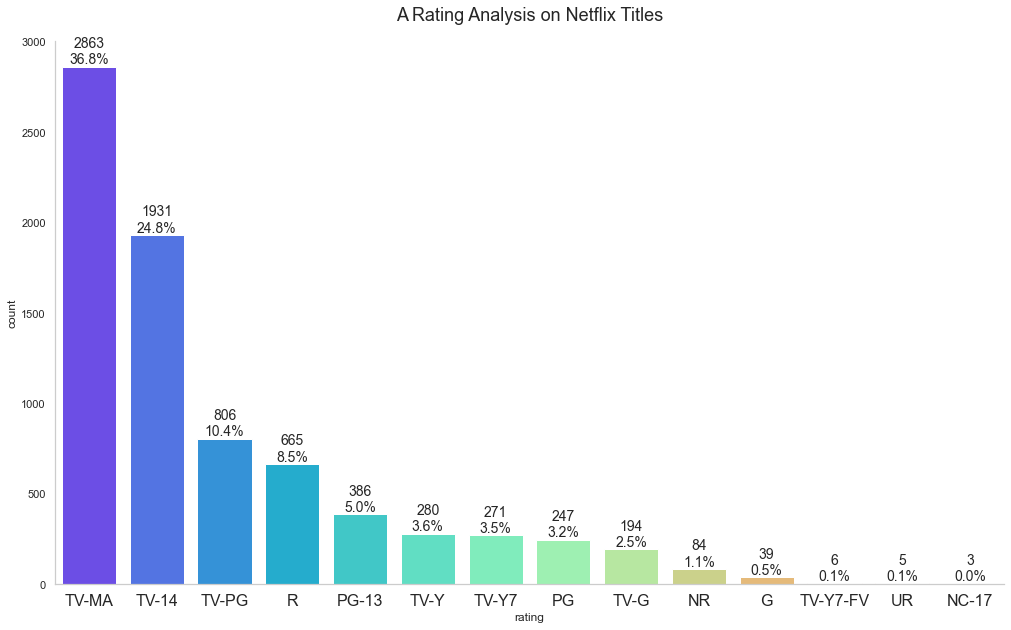

In [43]:
# Plotting and customizing a rating analysis
plot_countplot(df, 'rating', order=True, figsize=(17, 10),
               title='A Rating Analysis on Netflix Titles', size_title=18)
plt.xticks(fontsize=16)
plt.show()

Let's break the count analysis by title type.

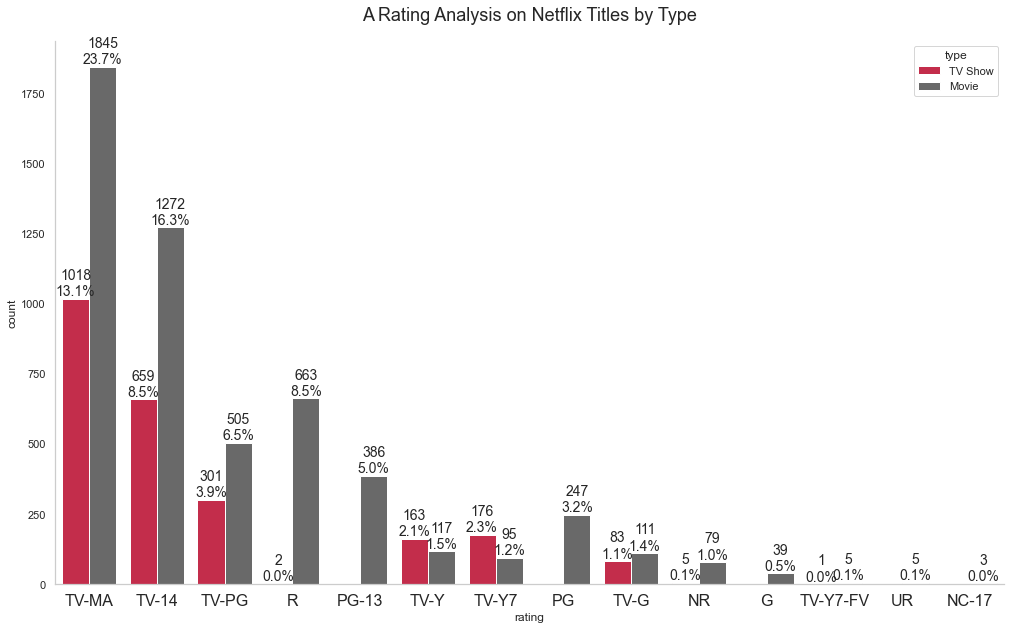

In [44]:
# Plotting and customizing a rating analysis
plot_countplot(df, 'rating', hue='type', order=True, figsize=(17, 10), palette=['crimson', 'dimgrey'],
               title='A Rating Analysis on Netflix Titles by Type', size_title=18)
plt.xticks(fontsize=16)
plt.show()

After extracting useful insights from data on a really extensive session with beautiful and insightful charts, let's purpose a new section for applying transformation on the raw data in order to create new columns and maybe be prepared for a further modeling step.

Who said we can't use this data for creating an unsupervised model for clustering titles and building a recommendation system? For making it formal, let's specify a wall of transformations that could be made using the data available. There are some new features that really could be used on relevant analysis.
